In [4]:
# library import
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.metrics import silhouette_score
#import plotly.offline as pyoff
#import plotly.graph_objs as go
from sklearn.preprocessing import StandardScaler

In [5]:
# load data
df=pd.read_excel(r"Online Retail.xlsx")
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France


#   Step 1 – Problem Understanding

-   Mục tiêu: Phân khúc khách hàng dựa trên hành vi mua hàng để hỗ trợ chiến lược marketing.

-   Phương pháp: Dựa trên mô hình RFM (Recency - Frequency - Monetary), phân cụm bằng K-Means.

 # Step 2 – Data Understanding

In [6]:
# Thông tin tổng quan
print("=== Thông tin chung ===")
print(df.info())

=== Thông tin chung ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB
None


In [7]:
# InvoiceNo: Mã đơn hàng 
# StockCode: Mã sản phẩm 
# Description: Mô tả sản phẩm 
# Quantity: Số lượng sản phẩm 
# InvoiceDate: Ngày hóa đơn 
# UnitPrice: Giá sản phẩm trên mỗi đơn vị 
# CustomerID: Mã khách hàng 
# Country: Quốc gia của khách hàng

In [8]:
#Kiểm tra số lượng giá trị thiếu theo từng cột
print("\n=== Số lượng giá trị thiếu ===")
print(df.isnull().sum())


=== Số lượng giá trị thiếu ===
InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


In [9]:
# Kiểm tra kiểu dữ liệu của các cột
print("\n=== Kiểu dữ liệu ===")
print(df.dtypes)


=== Kiểu dữ liệu ===
InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object


In [10]:
#Kiểm tra một số dòng đầu
print("\n=== 5 dòng đầu ===")
df.head()


=== 5 dòng đầu ===


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [11]:
#  Kiểm tra số dòng có giá trị âm hoặc bằng 0
print("\n=== Số dòng Quantity <= 0 ===")
print((df['Quantity'] <= 0).sum())


=== Số dòng Quantity <= 0 ===
10624


In [12]:
print("\n=== Số dòng UnitPrice <= 0 ===")
print((df['UnitPrice'] <= 0).sum())


=== Số dòng UnitPrice <= 0 ===
2517


In [13]:
# Số lượng khách hàng duy nhất (bỏ qua NaN)
print("\n=== Số lượng khách hàng duy nhất (có CustomerID) ===")
print(df['CustomerID'].nunique(dropna=True))


=== Số lượng khách hàng duy nhất (có CustomerID) ===
4372


In [14]:
#Khoảng thời gian giao dịch (InvoiceDate chưa chuyển sang datetime)
print("\n=== Khoảng thời gian InvoiceDate ===")
print("Từ:", df['InvoiceDate'].min(), "đến", df['InvoiceDate'].max())


=== Khoảng thời gian InvoiceDate ===
Từ: 2010-12-01 08:26:00 đến 2011-12-09 12:50:00


In [15]:
# kiểm tra col 'InvoiceNo' có ký tự nào khác ngoài số ko
df['InvoiceNo'].str.replace("[0-9]","",regex=True).unique()

array([nan, 'C', 'A'], dtype=object)

In [16]:
# Đếm số hóa đơn bắt đầu bằng 'C' (cancelled invoices)
cancelled_invoices = df[df['InvoiceNo'].str.startswith('C', na=False)]
print("=== Số hóa đơn bị hủy (bắt đầu bằng 'C') ===")
print(cancelled_invoices.shape[0])

# Đếm số hóa đơn có chứa 'A'
a_invoices = df[df['InvoiceNo'].str.contains('A', na=False)]
print("\n=== Số hóa đơn có chứa ký tự 'A' ===")
print(a_invoices.shape[0])

# (Tuỳ chọn) In một vài ví dụ để quan sát trực tiếp
print("\n=== Ví dụ hóa đơn bị hủy (C...) ===")
print(cancelled_invoices[['InvoiceNo', 'Quantity', 'CustomerID']].head())

print("\n=== Ví dụ hóa đơn chứa 'A' ===")
print(a_invoices[['InvoiceNo', 'Quantity', 'CustomerID']].head())


=== Số hóa đơn bị hủy (bắt đầu bằng 'C') ===
9288

=== Số hóa đơn có chứa ký tự 'A' ===
3

=== Ví dụ hóa đơn bị hủy (C...) ===
    InvoiceNo  Quantity  CustomerID
141   C536379        -1     14527.0
154   C536383        -1     15311.0
235   C536391       -12     17548.0
236   C536391       -24     17548.0
237   C536391       -24     17548.0

=== Ví dụ hóa đơn chứa 'A' ===
       InvoiceNo  Quantity  CustomerID
299982   A563185         1         NaN
299983   A563186         1         NaN
299984   A563187         1         NaN


In [17]:
# Tìm trong cột 'StockCode' có giá trị nào không đúng 5 chữ số và không có chữ cái kèm theo
df['StockCode']=df['StockCode'].astype('str')
# tìm trong cột 'StockCode' có giá trị nào không đúng 5 chữ số và không có chữ cái kèm theo
df[(df['StockCode'].str.match("^\\d{5}$")==False)&(df['StockCode'].str.match("^\\d{5}[a-zA-Z]+$")==False)]['StockCode'].unique()


array(['POST', 'D', 'C2', 'DOT', 'M', 'BANK CHARGES', 'S', 'AMAZONFEE',
       'DCGS0076', 'DCGS0003', 'gift_0001_40', 'DCGS0070', 'm',
       'gift_0001_50', 'gift_0001_30', 'gift_0001_20', 'DCGS0055',
       'DCGS0072', 'DCGS0074', 'DCGS0069', 'DCGS0057', 'DCGSSBOY',
       'DCGSSGIRL', 'gift_0001_10', 'PADS', 'DCGS0004', 'DCGS0073',
       'DCGS0071', 'DCGS0068', 'DCGS0067', 'DCGS0066P', 'B', 'CRUK'],
      dtype=object)

# Stock Code

- **Include** 🟢 → Giữ lại để phân tích hoặc clustering.  
- **Exclude** ❌ → Loại bỏ hoàn toàn, không dùng để phân tích.  
- **Exclude from clustering** 🚫 → Không dùng để phân nhóm nhưng có thể tham khảo.  
- **Exclude for now** ⏳ → Tạm loại bỏ, có thể xem xét lại sau. 

- **StockCode** is meant to follow the pattern `[0-9]{5}` but seems to have legit values for `[0-9]{5}[a-zA-Z]+`.  
&nbsp;&nbsp;&nbsp;&nbsp; **Also contains other values:** 



| Code             | Description                                                                 | Action                      |
|------------------|-----------------------------------------------------------------------------|-----------------------------|
| POST            | Not listed previously, likely a postage-related transaction                | Exclude for now             |
| D               | Looks valid, represents discount values                                    | Exclude from clustering     |
| C2              | Carriage transaction - not sure what this means                           | Exclude from clustering     |
| DOT             | Looks valid, represents postage charges                                   | Exclude from clustering     |
| M or m          | Looks valid, represents manual transactions                               | Exclude from clustering     |
| BANK CHARGES or B | Bank charges                                                           | Exclude from clustering     |
| S               | Samples sent to customer                                                 | Exclude from clustering     |
| AMAZONFEE       | Looks like fees for Amazon shipping or something                         | Exclude for now             |
| DCGS0076        | Variant of DCGS, likely falls under the same category                    | Exclude from clustering     |
| DCGS0003        | Variant of DCGS, likely falls under the same category                    | Exclude from clustering     |
| gift_0001_40    | Purchases with gift cards, might be interesting for another analysis, but no customer data | Exclude |
| DCGS0070        | Variant of DCGS, likely falls under the same category                    | Exclude from clustering     |
| m               | Looks valid, represents manual transactions                              | Exclude from clustering     |
| gift_0001_50    | Purchases with gift cards, might be interesting for another analysis, but no customer data | Exclude |
| gift_0001_30    | Purchases with gift cards, might be interesting for another analysis, but no customer data | Exclude |
| gift_0001_20    | Purchases with gift cards, might be interesting for another analysis, but no customer data | Exclude |
| DCGS0055        | Variant of DCGS, likely falls under the same category                    | Exclude from clustering     |
| DCGS0072        | Variant of DCGS, likely falls under the same category                    | Exclude from clustering     |
| DCGS0074        | Variant of DCGS, likely falls under the same category                    | Exclude from clustering     |
| DCGS0069        | Variant of DCGS, likely falls under the same category                    | Exclude from clustering     |
| DCGS0057        | Variant of DCGS, likely falls under the same category                    | Exclude from clustering     |
| DCGSSBOY        | Possible category or bundle-related code                                 | Exclude for now             |
| DCGSSGIRL       | Possible category or bundle-related code                                 | Exclude for now             |
| gift_0001_10    | Purchases with gift cards, might be interesting for another analysis, but no customer data | Exclude |
| PADS            | Looks like a legit stock code for padding                                | Include                     |
| DCGS0004        | Variant of DCGS, likely falls under the same category                    | Exclude from clustering     |
| DCGS0073        | Variant of DCGS, likely falls under the same category                    | Exclude from clustering     |
| DCGS0071        | Variant of DCGS, likely falls under the same category                    | Exclude from clustering     |
| DCGS0068        | Variant of DCGS, likely falls under the same category                    | Exclude from clustering     |
| DCGS0067        | Variant of DCGS, likely falls under the same category                    | Exclude from clustering     |
| DCGS0066P       | Variant of DCGS, possibly a special category                            | Exclude from clustering     |
| B               | Bank charges                                                             | Exclude from clustering     |
| CRUK            | Unknown, possibly a charity-related code                                | Exclude for now             |


-----------------------------------------------------------------------------------------------------------------------------

# Nhận xét Step - 2:

Quá trình khám phá dữ liệu cho thấy tập dữ liệu có cấu trúc hợp lý với 541.909 dòng và 8 cột chính, bao gồm thông tin về hóa đơn, sản phẩm, số lượng, giá đơn vị, ngày giao dịch, mã khách hàng và quốc gia

-   Vẫn tồn tại một số vấn đề chất lượng dữ liệu nổi bật cần được xử lý ở bước tiếp theo:

    -   Cột CustomerID thiếu 135.080 giá trị (chiếm khoảng 25%) khiến không thể xác định được danh tính khách hàng → cần loại bỏ những dòng này vì không thể gán nhóm RFM   

    -   Cột Quantity có 10.624 dòng mang giá trị âm hoặc bằng 0, nhiều khả năng là hàng bị trả lại hoặc lỗi nhập → cần loại bỏ để đảm bảo chỉ số RFM phản ánh hành vi mua hàng thực tế.

    -   Cột UnitPrice có 2.517 dòng ≤ 0, đây cũng là những giá trị không hợp lệ trong bối cảnh giao dịch thương mại.

    -   Thời gian giao dịch (InvoiceDate) kéo dài từ 01/12/2010 đến 09/12/2011, cho phép phân tích hành vi mua hàng trong vòng 1 năm.

    -   Có 4.372 khách hàng duy nhất (đã loại bỏ NaN) – đây sẽ là đối tượng mục tiêu để tính toán bảng RFM.

    -   Cột Country chứa dữ liệu quốc gia, tuy không ảnh hưởng trực tiếp đến việc tính RFM, nhưng có thể được giữ lại để phân tích sau theo vùng địa lý nếu cần

-   Cột InvoiceNo đại diện cho mã hóa đơn, với kỳ vọng ban đầu là chuỗi số duy nhất cho mỗi giao dịch. Nhưng quá trình khám phá cho thấy một số giá trị trong cột này chứa ký tự không phải số, đáng chú ý là:

    -   Các hóa đơn bắt đầu bằng ký tự 'C': biểu thị giao dịch bị hủy (Cancelled), thường đi kèm với giá trị Quantity âm.

    -   Một số hóa đơn chứa ký tự 'A', tuy không rõ ý nghĩa cụ thể nhưng không mang đặc điểm bất thường rõ rệt.

    -   Tiến hành loại bỏ ký tự đặc biệt

-   Cột StockCode lưu mã sản phẩm, tuy nhiên ngoài các mã thuần số hoặc dạng chữ-số hợp lệ (ví dụ 85123A), dữ liệu còn chứa nhiều mã không đại diện cho sản phẩm thật, ví dụ:

    -   Mã dịch vụ/phí: 'POST', 'BANK CHARGES', 'AMAZONFEE'

    -   Mã hệ thống/kỹ thuật: 'M', 'S', 'DCGS007x'

    -   Mã quà tặng: 'gift_0001_40', 'gift_0001_30' (thường không có CustomerID)

    -   Loại bỏ toàn bộ các dòng có StockCode không phải sản phẩm thực. Đặc biệt, trong phạm vi nghiên cứu, nhóm đã quyết định chỉ giữ lại các dòng có StockCode == 'PADS' để tập trung phân tích hành vi khách hàng đối với một sản phẩm cụ thể

---------------------------------------------------------------------------------------------------------

#   Step 3 – Data Preparation

In [18]:
# Copy dữ liệu gốc để xử lý
df_cleaned = df.copy()

In [19]:
#Xử lý 'InvoiceNo'
# Chuyển về kiểu chuỗi
df_cleaned['InvoiceNo'] = df_cleaned['InvoiceNo'].astype(str)
# Giữ lại các hóa đơn đúng định dạng 6 chữ số
invoice_mask = df_cleaned['InvoiceNo'].str.match(r'^\d{6}$')
df_cleaned = df_cleaned[invoice_mask]
# Kiểm tra lại số lượng hóa đơn
print("\n=== Số lượng hóa đơn sau khi xử lý ===")
print(df_cleaned['InvoiceNo'].nunique())


=== Số lượng hóa đơn sau khi xử lý ===
22061


In [20]:
# Bước 3: Xử lý 'StockCode'
df_cleaned['StockCode'] = df_cleaned['StockCode'].astype(str)
stockcode_mask = (
    df_cleaned['StockCode'].str.match(r'^\d{5}$') |
    df_cleaned['StockCode'].str.match(r'^\d{5}[a-zA-Z]+$') |
    df_cleaned['StockCode'].str.match(r'^PADS$')
)
df_cleaned = df_cleaned[stockcode_mask]
df_cleaned

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France


In [21]:
#   Xoá dòng thiếu CustomerID
df_cleaned.dropna(subset=['CustomerID'], inplace=True)

In [22]:
# Chuyển đổi cột 'InvoiceDate' vs 'CustomerID' về kiểu dữ liệu datetime và int
# Chuyển đổi cột 'InvoiceDate' về kiểu datetime
df_cleaned['InvoiceDate'] = pd.to_datetime(df_cleaned['InvoiceDate'])
# Chuyển đổi cột 'CustomerID' về kiểu int (loại bỏ giá trị NaN trước)
df_cleaned['CustomerID'] = df_cleaned['CustomerID'].astype(int)
#Kiểm tra lại kiểu dữ liệu
print("\n=== Kiểu dữ liệu sau khi chuyển đổi ===")
print(df_cleaned.dtypes)


=== Kiểu dữ liệu sau khi chuyển đổi ===
InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID              int64
Country                object
dtype: object


In [23]:
#   Xoá dòng có giá trị bất thường
df_cleaned = df_cleaned[df_cleaned['Quantity'] > 0]
df_cleaned = df_cleaned[df_cleaned['UnitPrice'] > 0]

In [24]:
#   Kiểm tra tóm tắt dữ liệu sau làm sạch
print("Số dòng còn lại:", len(df_cleaned))
print("Số khách hàng duy nhất:", df_cleaned['CustomerID'].nunique())
print("Ngày giao dịch từ:", df_cleaned['InvoiceDate'].min().date(), 
      "đến", df_cleaned['InvoiceDate'].max().date())#

Số dòng còn lại: 396340
Số khách hàng duy nhất: 4334
Ngày giao dịch từ: 2010-12-01 đến 2011-12-09


In [25]:
# (Tuỳ chọn) Kiểm tra tỷ lệ dữ liệu còn lại so với ban đầu
print("Tỷ lệ dữ liệu giữ lại: {:.2f}%".format(100 * len(df_cleaned) / len(df)))

Tỷ lệ dữ liệu giữ lại: 73.14%


In [26]:
# thống kê data sau khi drop na
df_cleaned.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID
count,396340.000000,396340,396340.000000,396340.000000
mean,13.012456,2011-07-11 00:04:40.164908544,2.868200,15301.689070
min,1.000000,2010-12-01 08:26:00,0.001000,12346.000000
25%,2.000000,2011-04-07 11:16:00,1.250000,13975.000000
50%,6.000000,2011-07-31 14:39:00,1.950000,15159.000000
75%,12.000000,2011-10-20 14:41:00,3.750000,16803.000000
max,80995.000000,2011-12-09 12:50:00,649.500000,18287.000000
std,179.640568,NaN,4.264654,1709.957487


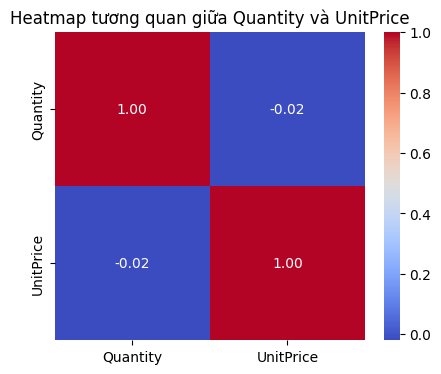

In [27]:
# Heatmap tương quan giữa Quantity và UnitPrice
plt.figure(figsize=(5, 4))
sns.heatmap(df_cleaned[['Quantity', 'UnitPrice']].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Heatmap tương quan giữa Quantity và UnitPrice")
plt.show()

-   Nhóm đã tiến hành kiểm tra mức độ tương quan giữa Quantity và UnitPrice để hiểu rõ hơn mối quan hệ giữa số lượng mua và đơn giá – hai yếu tố cấu thành chỉ số Monetary trong RFM.
-   Kết quả cho thấy mức tương quan khá thấp (gần 0), cho thấy hai biến này có xu hướng độc lập. Điều này khẳng định rằng việc nhân hai biến để tạo ra MonetaryValue là hợp lý và không gây trùng lặp thông tin

-----------------------------------------------------------------------------

#   Nhận xét Step - 3: 

Sau quá trình khám phá dữ liệu ở bước 2, nhóm đã tiến hành xử lý và chuẩn hóa dữ liệu để đảm bảo rằng chỉ những giao dịch hợp lệ, đầy đủ và phản ánh đúng hành vi mua hàng mới được sử dụng cho bước tính RFM và phân cụm khách hàng. Dưới đây là các bước thực hiện cụ thể:

-   1. Loại bỏ hóa đơn không hợp lệ (InvoiceNo):
    -   Chuyển cột InvoiceNo về kiểu chuỗi để xử lý định dạng.
    -   Chỉ giữ lại các hóa đơn có đúng 6 chữ số (^\d{6}$), loại bỏ các hóa đơn bị hủy (bắt đầu bằng "C") và hóa đơn có chứa ký tự bất thường như “A”.
-   2. Lọc mã sản phẩm hợp lệ (StockCode)
    -   Giữ lại các dòng có mã sản phẩm hợp lệ gồm:
        -   Chuỗi 5 chữ số (^\d{5}$)
        -   5 chữ số kèm ký tự chữ cái (^\d{5}[a-zA-Z]+$)
        -   Mã 'PADS' – là sản phẩm trọng tâm được chọn để phân tích hành vi mua hàng.
    -   Các mã không phản ánh giao dịch mua hàng (như POST, BANK CHARGES, gift_0001_30,…) được loại bỏ hoàn toàn.
-   3. Loại bỏ dòng không có CustomerID
    -   Những dòng thiếu mã khách hàng không thể gán nhóm RFM nên được loại bỏ triệt để.
-   4. Loại bỏ giao dịch không hợp lệ
    -   Gỡ bỏ toàn bộ các dòng có Quantity ≤ 0 hoặc UnitPrice ≤ 0, vốn là các giao dịch sai hoặc hoàn trả, không phản ánh giá trị tiêu dùng thực sự.
-   5. Xử lý định dạng cột và thống kê lại dữ liệu
    -   Chuyển CustomerID về kiểu int.
    -   Chuyển InvoiceDate về định dạng datetime.
    -   Sau xử lý, còn lại 396.340 dòng dữ liệu hợp lệ, tương đương ~73.14% dữ liệu ban đầu.
    -   Số lượng khách hàng duy nhất còn lại là 4.334, với khoảng thời gian giao dịch kéo dài từ 01/12/2010 đến 09/12/2011, phù hợp để phân tích hành vi khách hàng trong một chu kỳ kinh doanh đầy đủ.
-   6. Phân tích mối quan hệ giữa Quantity và UnitPrice
    -   Nhóm đã tiến hành kiểm tra tương quan giữa hai biến đầu vào tạo nên chỉ số Monetary – đó là Quantity và UnitPrice.
    -   Kết quả heatmap cho thấy hai biến này hầu như không có tương quan tuyến tính rõ rệt, cho thấy đơn giá và số lượng mua không phụ thuộc lẫn nhau.
    -   Việc kết hợp hai biến này để tính MonetaryValue là hợp lý, không gây dư thừa thông tin.

------------------------------------------------------------------------------------

# Step 4 – Feature Engineering (Tính RFM) 

In [28]:
# tạo cột mới 'SalesLineTotal' = 'Quantity' * 'UnitPrice'
df_cleaned["SalesLineTotal"] = df_cleaned["Quantity"] * df_cleaned["UnitPrice"]
df_cleaned

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,SalesLineTotal
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680,France,10.20
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680,France,12.60
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680,France,16.60
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680,France,16.60


In [29]:
# Nhóm theo CustomerID và tính toán các chỉ số RFM
aggregated_df = df_cleaned.groupby("CustomerID", as_index=False).agg(
    MonetaryValue=("SalesLineTotal", "sum"),
    Frequency=("InvoiceNo", "nunique"),
    LastInvoiceDate=("InvoiceDate", "max")
)

aggregated_df

,CustomerID,MonetaryValue,Frequency,LastInvoiceDate
0,12346,77183.60,1,2011-01-18 10:01:00
1,12347,4310.00,7,2011-12-07 15:52:00
2,12348,1437.24,4,2011-09-25 13:13:00
3,12349,1457.55,1,2011-11-21 09:51:00
4,12350,294.40,1,2011-02-02 16:01:00
...,...,...,...,...
4329,18280,180.60,1,2011-03-07 09:52:00
4330,18281,80.82,1,2011-06-12 10:53:00
4331,18282,178.05,2,2011-12-02 11:43:00
4332,18283,2088.93,16,2011-12-06 12:02:00


In [30]:
# Tính Recency (ngày kể từ lần mua gần nhất)
max_invoice_date = aggregated_df["LastInvoiceDate"].max()
aggregated_df["Recency"] = (max_invoice_date - aggregated_df["LastInvoiceDate"]).dt.days

# Loại bỏ cột LastInvoiceDate vì không cần thiết nữa
aggregated_df.drop("LastInvoiceDate", axis=1, inplace=True)

In [31]:
aggregated_df

,CustomerID,MonetaryValue,Frequency,Recency
0,12346,77183.60,1,325
1,12347,4310.00,7,1
2,12348,1437.24,4,74
3,12349,1457.55,1,18
4,12350,294.40,1,309
...,...,...,...,...
4329,18280,180.60,1,277
4330,18281,80.82,1,180
4331,18282,178.05,2,7
4332,18283,2088.93,16,3


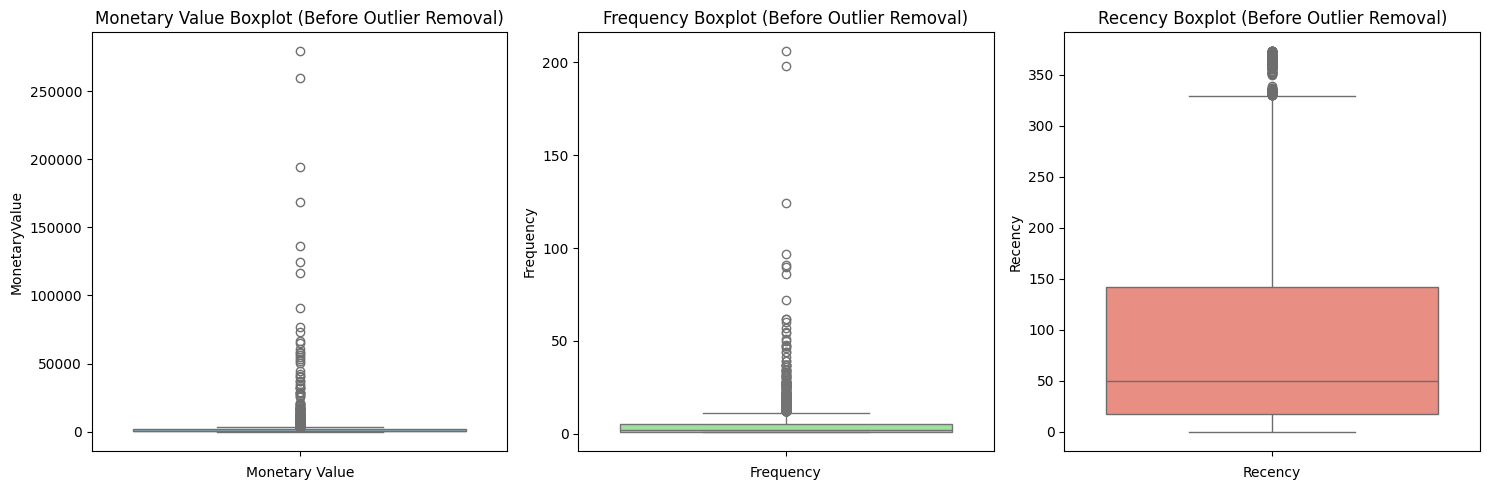

In [32]:
# Vẽ Boxplot cho các biến RFM trước khi loại bỏ outlier
plt.figure(figsize=(15, 5))

# Boxplot cho Monetary Value
plt.subplot(1, 3, 1)
sns.boxplot(data=aggregated_df['MonetaryValue'], color='skyblue')
plt.title('Monetary Value Boxplot (Before Outlier Removal)')
plt.xlabel('Monetary Value')

# Boxplot cho Frequency
plt.subplot(1, 3, 2)
sns.boxplot(data=aggregated_df['Frequency'], color='lightgreen')
plt.title('Frequency Boxplot (Before Outlier Removal)')
plt.xlabel('Frequency')

# Boxplot cho Recency
plt.subplot(1, 3, 3)
sns.boxplot(data=aggregated_df['Recency'], color='salmon')
plt.title('Recency Boxplot (Before Outlier Removal)')
plt.xlabel('Recency')

plt.tight_layout()
plt.show()


In [33]:
# Phát hiện outlier cho 'MonetaryValue'
M_Q1 = aggregated_df["MonetaryValue"].quantile(0.25)
M_Q3 = aggregated_df["MonetaryValue"].quantile(0.75)
M_IQR = M_Q3 - M_Q1

monetary_outliers_df = aggregated_df[
    (aggregated_df["MonetaryValue"] > (M_Q3 + 1.5 * M_IQR)) | 
    (aggregated_df["MonetaryValue"] < (M_Q1 - 1.5 * M_IQR))
]
print("=== Số lượng outlier trong MonetaryValue ===")
print(monetary_outliers_df.shape[0])
print("--------------------------------------------------")
# Phát hiện outlier cho 'Frequency'
F_Q1 = aggregated_df['Frequency'].quantile(0.25)
F_Q3 = aggregated_df['Frequency'].quantile(0.75)
F_IQR = F_Q3 - F_Q1

frequency_outliers_df = aggregated_df[
    (aggregated_df['Frequency'] > (F_Q3 + 1.5 * F_IQR)) | 
    (aggregated_df['Frequency'] < (F_Q1 - 1.5 * F_IQR))
]
print("=== Số lượng outlier trong Frequency ===")
print(frequency_outliers_df.shape[0])

=== Số lượng outlier trong MonetaryValue ===
425
--------------------------------------------------
=== Số lượng outlier trong Frequency ===
278


In [34]:
# Loại bỏ outliers
non_outliers_df = aggregated_df[
    (~aggregated_df.index.isin(monetary_outliers_df.index)) & 
    (~aggregated_df.index.isin(frequency_outliers_df.index))
]
print("=== Số lượng khách hàng sau khi loại bỏ outliers ===")
print(non_outliers_df.shape[0])

=== Số lượng khách hàng sau khi loại bỏ outliers ===
3863


In [35]:
# Hiển thị thống kê dữ liệu sau khi loại bỏ outliers
non_outliers_df.describe()

,CustomerID,MonetaryValue,Frequency,Recency
count,3863.000000,3863.000000,3863.000000,3863.000000
mean,15323.852705,853.814417,2.755113,99.943826
std,1709.731704,794.608100,2.168124,101.866688
min,12348.000000,3.750000,1.000000,0.000000
25%,13850.500000,278.500000,1.000000,21.000000
50%,15333.000000,570.460000,2.000000,58.000000
75%,16798.000000,1187.005000,4.000000,160.000000
max,18287.000000,3619.170000,11.000000,373.000000


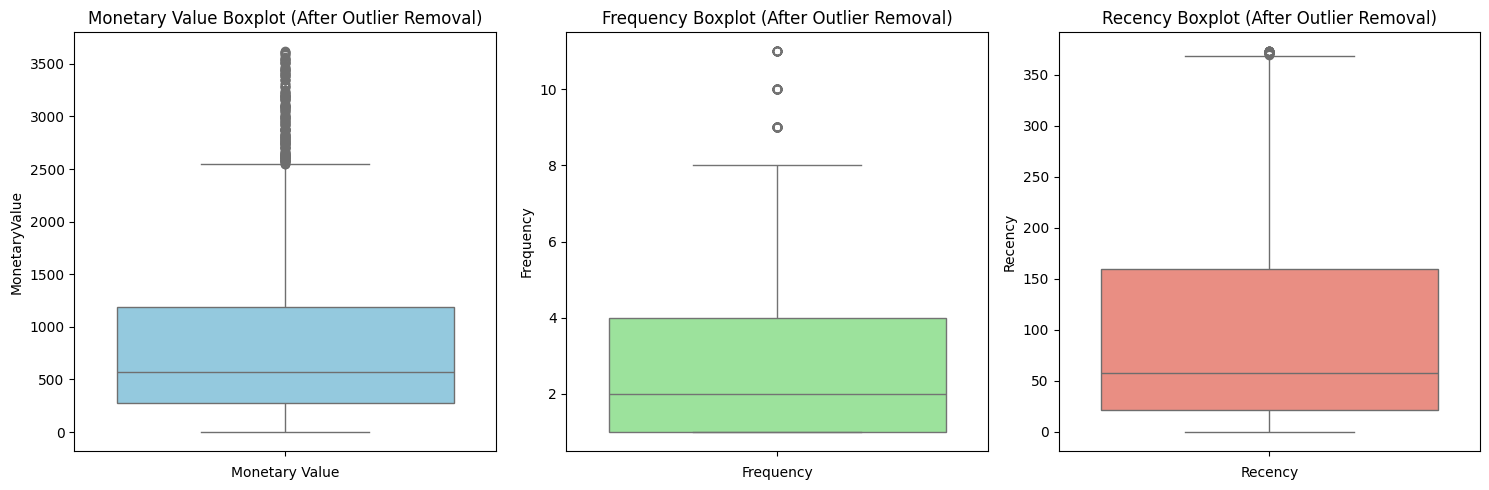

In [36]:
# Vẽ Boxplot cho các biến RFM sau khi loại bỏ outlier
plt.figure(figsize=(15, 5))

# Boxplot cho Monetary Value
plt.subplot(1, 3, 1)
sns.boxplot(data=non_outliers_df['MonetaryValue'], color='skyblue')
plt.title('Monetary Value Boxplot (After Outlier Removal)')
plt.xlabel('Monetary Value')

# Boxplot cho Frequency
plt.subplot(1, 3, 2)
sns.boxplot(data=non_outliers_df['Frequency'], color='lightgreen')
plt.title('Frequency Boxplot (After Outlier Removal)')
plt.xlabel('Frequency')

# Boxplot cho Recency
plt.subplot(1, 3, 3)
sns.boxplot(data=non_outliers_df['Recency'], color='salmon')
plt.title('Recency Boxplot (After Outlier Removal)')
plt.xlabel('Recency')

plt.tight_layout()
plt.show()


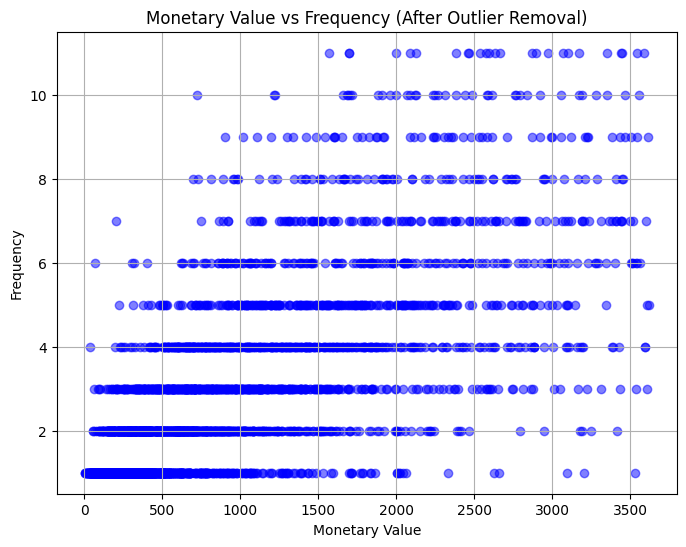

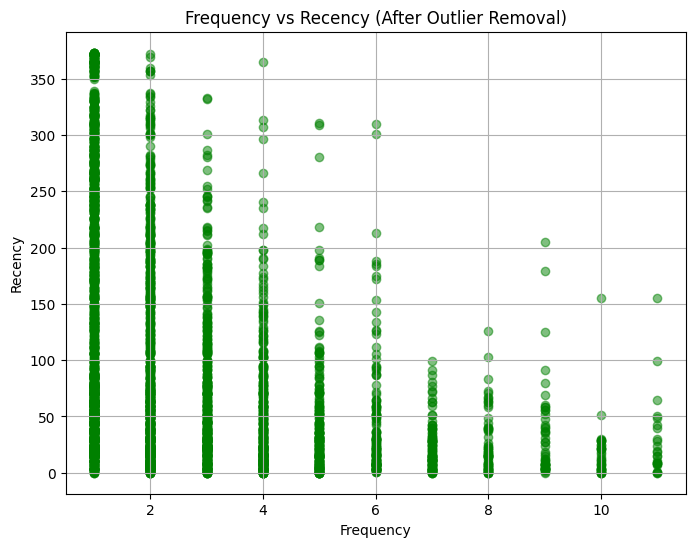

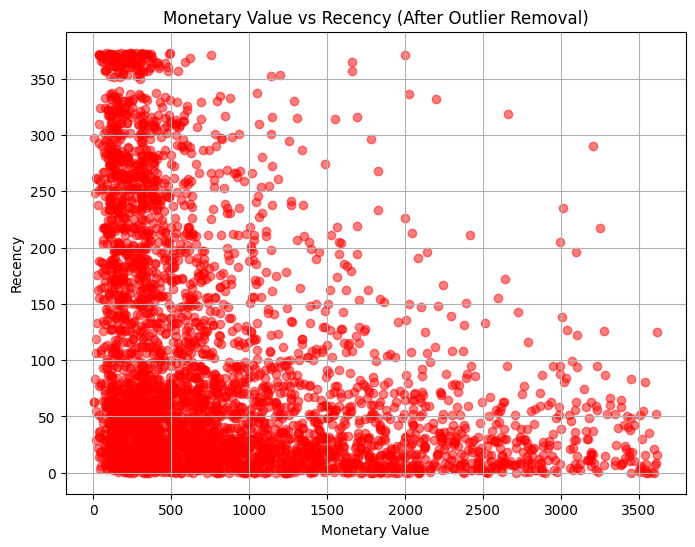

In [37]:
# Vẽ Scatter Plot để kiểm tra outlier (Monetary vs Frequency)
plt.figure(figsize=(8, 6))
plt.scatter(non_outliers_df['MonetaryValue'], non_outliers_df['Frequency'], c='blue', alpha=0.5)
plt.title('Monetary Value vs Frequency (After Outlier Removal)')
plt.xlabel('Monetary Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Vẽ Scatter Plot để kiểm tra outlier (Frequency vs Recency)
plt.figure(figsize=(8, 6))
plt.scatter(non_outliers_df['Frequency'], non_outliers_df['Recency'], c='green', alpha=0.5)
plt.title('Frequency vs Recency (After Outlier Removal)')
plt.xlabel('Frequency')
plt.ylabel('Recency')
plt.grid(True)
plt.show()

# Vẽ Scatter Plot để kiểm tra outlier (Monetary vs Recency)
plt.figure(figsize=(8, 6))
plt.scatter(non_outliers_df['MonetaryValue'], non_outliers_df['Recency'], c='red', alpha=0.5)
plt.title('Monetary Value vs Recency (After Outlier Removal)')
plt.xlabel('Monetary Value')
plt.ylabel('Recency')
plt.grid(True)
plt.show()


1.  Monetary Value vs Frequency (After Outlier Removal)

-   Biểu đồ cho thấy mối quan hệ giữa giá trị tiền tệ (Monetary Value) và tần suất (Frequency) của khách hàng.

-   Phần lớn các điểm có tần suất giao dịch thấp (gần 2), trong khi giá trị tiền tệ (Monetary Value) của họ lại có sự phân tán rõ rệt.

-   Có thể thấy rằng, một số khách hàng mua nhiều sản phẩm, nhưng giá trị của các giao dịch không quá cao.

-   Phân bố khá đồng đều và không có các giá trị ngoại lai rõ rệt nữa sau khi loại bỏ.

2.  Frequency vs Recency (After Outlier Removal)

-   Biểu đồ này thể hiện mối quan hệ giữa tần suất (Frequency) và thời gian gần đây (Recency) của khách hàng.

-   Sự phân bố cho thấy một lượng lớn các điểm có tần suất giao dịch thấp, nhưng những người có tần suất giao dịch cao thì có thời gian gần đây thấp hơn.

-   Các điểm dữ liệu cho thấy mối quan hệ rõ rệt giữa tần suất và thời gian gần đây sau khi loại bỏ outliers, chỉ ra rằng các khách hàng có xu hướng quay lại mua hàng thường xuyên sau khi một thời gian dài không giao dịch.

3.  Monetary Value vs Recency (After Outlier Removal)

-   Biểu đồ này mô tả mối quan hệ giữa giá trị tiền tệ (Monetary Value) và thời gian gần đây (Recency).

-   Có thể nhận thấy rằng, những khách hàng có giá trị giao dịch cao (Monetary Value) lại có thời gian giao dịch khá lâu rồi (Recency) so với những khách hàng có giá trị giao dịch thấp.

-   Sự phân tán dữ liệu khá lớn, nhưng với việc loại bỏ outlier, biểu đồ này thể hiện sự rõ ràng hơn trong mối quan hệ giữa giá trị giao dịch và thời gian.

Text(0.5, 0.92, '3D Scatter Plot of Customer Data')

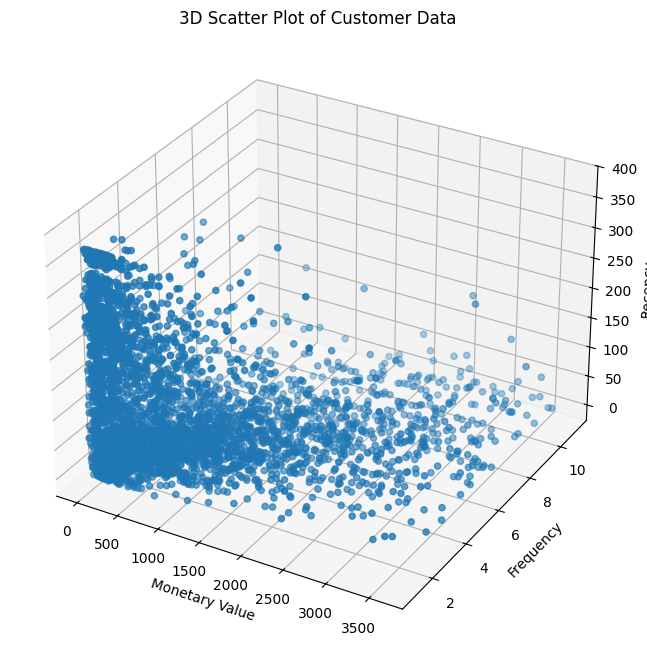

In [38]:
# 3D scatter plot
fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(projection="3d")

scatter = ax.scatter(non_outliers_df["MonetaryValue"], non_outliers_df["Frequency"], non_outliers_df["Recency"])

ax.set_xlabel('Monetary Value')
ax.set_ylabel('Frequency')
ax.set_zlabel('Recency')

ax.set_title('3D Scatter Plot of Customer Data')


In [39]:
# Chuẩn hóa dữ liệu RFM (Monetary, Frequency, Recency)
scaler = StandardScaler()

# Áp dụng chuẩn hóa trên 3 cột: MonetaryValue, Frequency, Recency
scaled_data = scaler.fit_transform(non_outliers_df[["MonetaryValue", "Frequency", "Recency"]])

# Chuyển dữ liệu đã chuẩn hóa thành DataFrame
scaled_data_df = pd.DataFrame(scaled_data, index=non_outliers_df.index, columns=["MonetaryValue", "Frequency", "Recency"])

# Kiểm tra dữ liệu đã chuẩn hóa
scaled_data_df.describe()


,MonetaryValue,Frequency,Recency
count,3.863000e+03,3.863000e+03,3.863000e+03
mean,3.678709e-18,-1.213974e-16,1.195581e-17
std,1.000129e+00,1.000129e+00,1.000129e+00
min,-1.069929e+00,-8.096124e-01,-9.812508e-01
25%,-7.241166e-01,-8.096124e-01,-7.750723e-01
50%,-3.566426e-01,-3.483244e-01,-4.118054e-01
75%,4.193686e-01,5.742516e-01,5.896329e-01
max,3.480601e+00,3.803268e+00,2.680872e+00


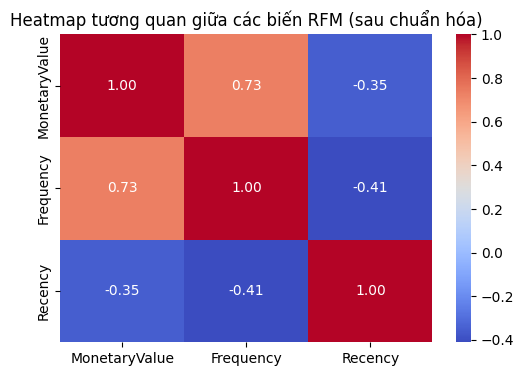

In [40]:
# Heatmap tương quan giữa các biến RFM sau khi chuẩn hóa
plt.figure(figsize=(6, 4))
sns.heatmap(scaled_data_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Heatmap tương quan giữa các biến RFM (sau chuẩn hóa)")
plt.show()

### Nhận xét về ma trận tương quan:
1.  Monetary Value và Frequency:

    -   Tương quan giữa Monetary Value và Frequency là 0.73, tức là có mối quan hệ khá mạnh mẽ và tích cực giữa giá trị tiền tệ và số lần mua hàng. Điều này cho thấy rằng khách hàng chi tiêu nhiều sẽ thường xuyên mua hàng hơn.

2.  Monetary Value và Recency:

    -   Tương quan giữa Monetary Value và Recency là -0.35, tức là có mối quan hệ yếu và âm giữa giá trị tiền tệ và thời gian gần nhất mua hàng. Điều này có thể cho thấy rằng khách hàng chi tiêu nhiều có thể là những người mua hàng trước đó khá lâu rồi, nhưng chưa quay lại gần đây.

3.  Frequency và Recency:

    -   Tương quan giữa Frequency và Recency là -0.41, tức là cũng có một mối quan hệ âm khá mạnh giữa số lần mua hàng và thời gian gần nhất mua hàng. Điều này phản ánh rằng những khách hàng mua hàng nhiều thường có xu hướng mua gần đây hơn, tức là họ là những khách hàng "nóng".

Text(0.5, 0.92, '3D Scatter Plot of Customer Data')

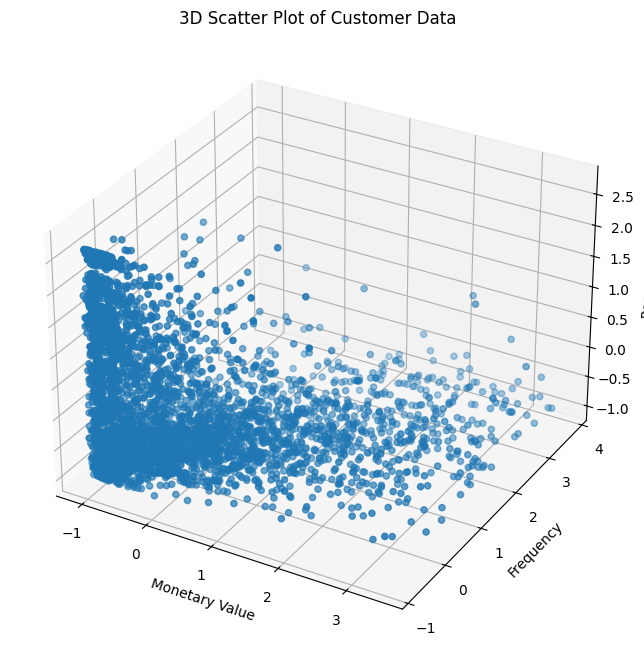

In [41]:
# 3D scatter plot after scaler
fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(projection="3d")

scatter = ax.scatter(scaled_data_df["MonetaryValue"], scaled_data_df["Frequency"], scaled_data_df["Recency"])

ax.set_xlabel('Monetary Value')
ax.set_ylabel('Frequency')
ax.set_zlabel('Recency')

ax.set_title('3D Scatter Plot of Customer Data')


------------------------------------------------------------------------------------------------------


#   Nhận xét Step - 4: 



1.  Tạo các cột mới:

-   Tạo cột SalesLineTotal (tổng giá trị đơn hàng) và tính toán các chỉ số RFM: Monetary Value, Frequency, Recency.

2.  Kiểm tra và xử lý ngoại lệ:

-   Sử dụng boxplot và scatter plot để kiểm tra các ngoại lệ trong các chỉ số RFM. Ngoại lệ đã được loại bỏ, làm sạch dữ liệu.

3.  Tạo heatmap:

-   Heatmap giúp kiểm tra tương quan giữa các biến RFM, cho thấy Monetary và Frequency có mối quan hệ mạnh, trong khi Recency có tương quan yếu với cả hai.

4.  Visualizations:

-   Các scatter plot giúp hình dung mối quan hệ giữa các chỉ số RFM, hỗ trợ việc hiểu rõ hơn về phân bố dữ liệu.

5.  Chuẩn hóa dữ liệu:

-   Dữ liệu sau khi loại bỏ ngoại lệ và chuẩn hóa sẽ giúp việc phân nhóm chính xác hơn và tránh ảnh hưởng từ các đơn vị đo khác nhau.

**Kết luận**: Step - 4 đã xử lý hiệu quả dữ liệu, loại bỏ các ngoại lệ và tạo ra các chỉ số RFM chính xác, sẵn sàng cho phân tích phân cụm tiếp theo.

---------------------------------------------------------

Thế Anh làm theo step này nha 
Step 5: Phân nhóm khách hàng (Clustering)
K-Means: Áp dụng thuật toán K-Means để phân nhóm khách hàng dựa trên các chỉ số RFM. Đảm bảo xác định đúng số lượng cụm (k) qua phương pháp Elbow hoặc Silhouette Score. (làm nhiều phương pháp hơn để so sánh)

Step 6: Đánh giá mô hình phân nhóm
Sử dụng Silhouette Score hoặc Inertia để đánh giá chất lượng phân nhóm. (hoặc nhiều hơn)
Kiểm tra sự phân bố của các cụm trong không gian 2D/3D để xác nhận tính hợp lý của phân nhóm.

Step 7: Trực quan hóa và phân tích kết quả
Violin plot và boxplot để trực quan hóa sự phân bố của các chỉ số RFM trong từng nhóm.
3D Scatter plot để kiểm tra sự phân tách giữa các cụm

Step 8: Kết luận và báo cáo
Tổng hợp lại các kết quả từ phân tích phân cụm, mô tả các đặc điểm của mỗi nhóm khách hàng.
Đề xuất chiến lược marketing dựa trên các đặc điểm của từng nhóm (ví dụ: nhóm "RETAIN", "RE-ENGAGE", "NURTURE"...) để tăng cường mối quan hệ với khách hàng.


# K-Means Clustering

In [42]:
from sklearn.cluster import KMeans

In [43]:
max_k = 15

In [44]:
inertia = []
silhoutte_scores = []

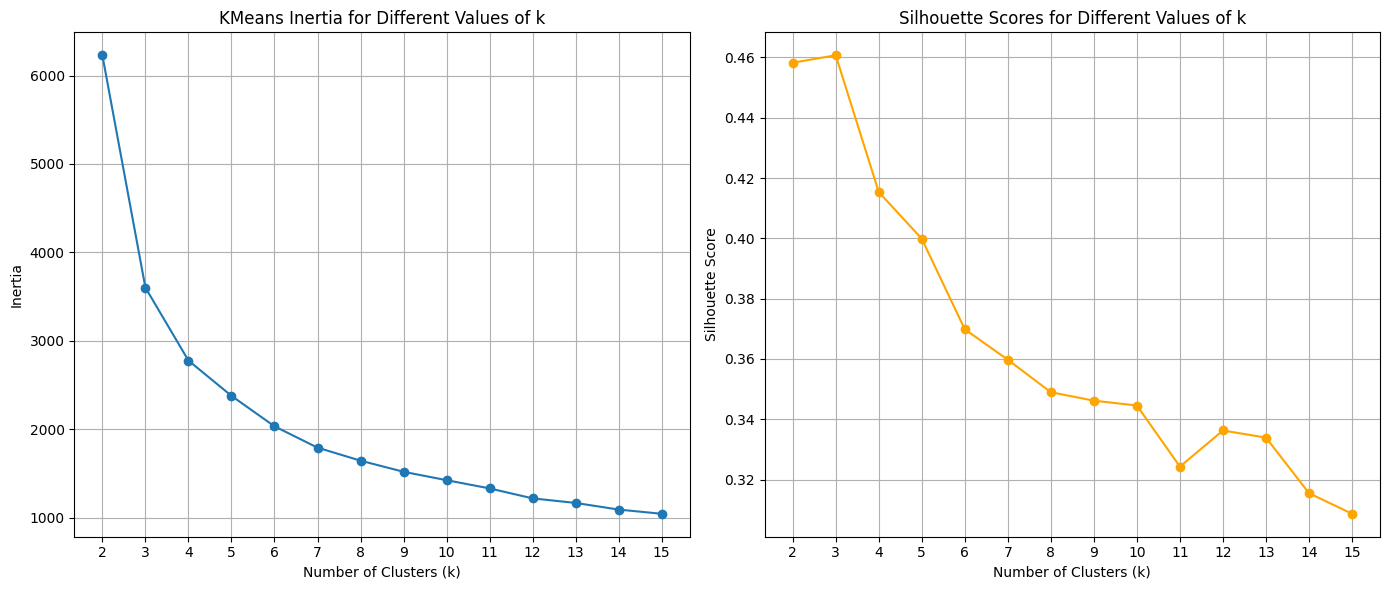

In [45]:
k_values = range(2, max_k + 1)

for k in k_values:

    kmeans = KMeans(n_clusters=k, random_state=42, max_iter=1000)

    cluster_labels = kmeans.fit_predict(scaled_data_df)

    sil_score = silhouette_score(scaled_data_df, cluster_labels)

    silhoutte_scores.append(sil_score)

    inertia.append(kmeans.inertia_)

plt.figure(figsize=(14, 6))
# elbow
plt.subplot(1, 2, 1)
plt.plot(k_values, inertia, marker='o')
plt.title('KMeans Inertia for Different Values of k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.xticks(k_values)
plt.grid(True)
# silhouette
plt.subplot(1, 2, 2)
plt.plot(k_values, silhoutte_scores, marker='o', color='orange')
plt.title('Silhouette Scores for Different Values of k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.xticks(k_values)
plt.grid(True)

plt.tight_layout()
plt.show()

từ 2 phương pháp xác định k ở trên thì đã tìm được số k phù hợp đó chính là k=3

In [46]:
# khoi tao model
kmeans = KMeans(n_clusters=4, random_state=42, max_iter=1000)

cluster_labels = kmeans.fit_predict(scaled_data_df)

cluster_labels

array([3, 0, 1, ..., 1, 0, 3], shape=(3863,), dtype=int32)

In [47]:
# them nhãn vào df
non_outliers_df["Cluster"] = cluster_labels

non_outliers_df

C:\Users\thean\AppData\Local\Temp\ipykernel_1304\2049932316.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_outliers_df["Cluster"] = cluster_labels


,CustomerID,MonetaryValue,Frequency,Recency,Cluster
2,12348,1437.24,4,74,3
3,12349,1457.55,1,18,0
4,12350,294.40,1,309,1
5,12352,1385.74,7,35,2
6,12353,89.00,1,203,1
...,...,...,...,...,...
4328,18278,173.90,1,73,0
4329,18280,180.60,1,277,1
4330,18281,80.82,1,180,1
4331,18282,178.05,2,7,0


Silhouette Score trung bình: 0.415


C:\Users\thean\AppData\Local\Temp\ipykernel_1304\1860784092.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(range(n_clusters)), y=silhouette_per_cluster, palette='viridis')


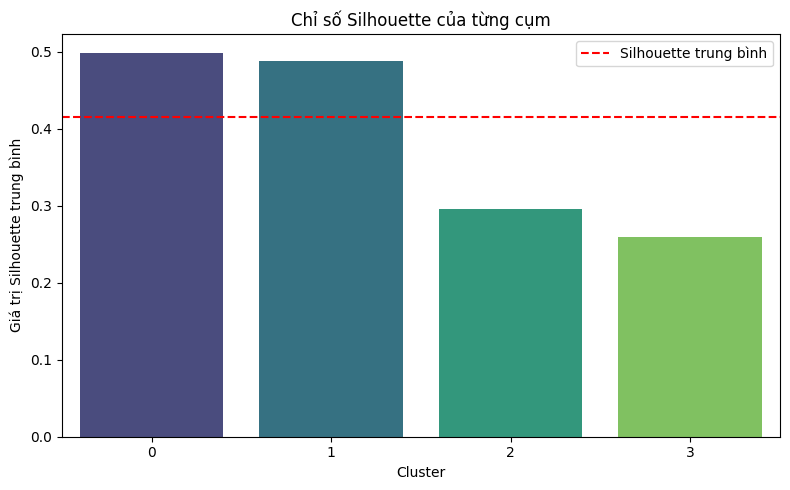

In [48]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Lấy nhãn cụm từ dataframe (đảm bảo là 1D array)
cluster_labels = non_outliers_df["Cluster"] #.to_numpy()

# Tính chỉ số silhouette cho từng điểm
silhouette_vals = silhouette_samples(scaled_data_df, cluster_labels)

# Tính chỉ số silhouette trung bình
silhouette_avg = silhouette_score(scaled_data_df, cluster_labels)
print(f"Silhouette Score trung bình: {silhouette_avg:.3f}")

# Tính silhouette trung bình cho từng cụm
n_clusters = len(np.unique(cluster_labels))
silhouette_per_cluster = []

for i in range(n_clusters):
    cluster_silhouette = silhouette_vals[cluster_labels == i]
    silhouette_per_cluster.append(np.mean(cluster_silhouette))

# Vẽ biểu đồ
plt.figure(figsize=(8, 5))
sns.barplot(x=list(range(n_clusters)), y=silhouette_per_cluster, palette='viridis')
plt.axhline(y=silhouette_avg, color='red', linestyle='--', label='Silhouette trung bình')
plt.xlabel('Cluster')
plt.ylabel('Giá trị Silhouette trung bình')
plt.title('Chỉ số Silhouette của từng cụm')
plt.legend()
plt.tight_layout()
plt.show()


Text(0.5, 0.92, '3D Scatter Plot of Customer Data by Cluster')

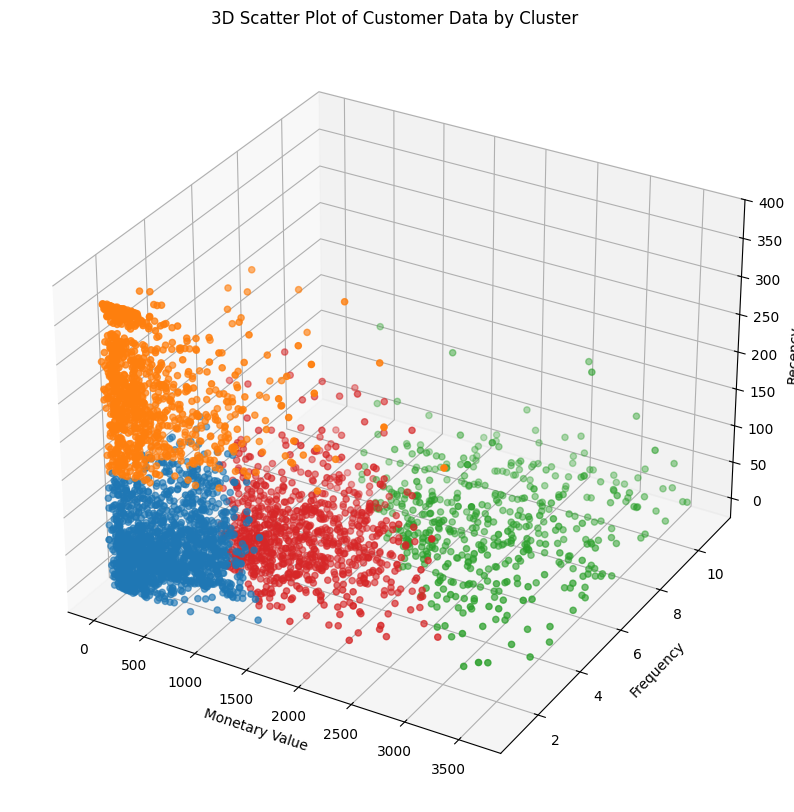

In [49]:
# 
cluster_colors = {0: '#1f77b4',  # xanh 
                  1: '#ff7f0e',  # cam
                  2: '#2ca02c',  # xanh la
                  3: '#d62728'}  # đỏ
# ánh xạ màu cho các cụm
colors = non_outliers_df['Cluster'].map(cluster_colors)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')

scatter = ax.scatter(non_outliers_df['MonetaryValue'], 
                     non_outliers_df['Frequency'], 
                     non_outliers_df['Recency'], 
                     c=colors, 
                     marker='o')

ax.set_xlabel('Monetary Value')
ax.set_ylabel('Frequency')
ax.set_zlabel('Recency')

ax.set_title('3D Scatter Plot of Customer Data by Cluster')

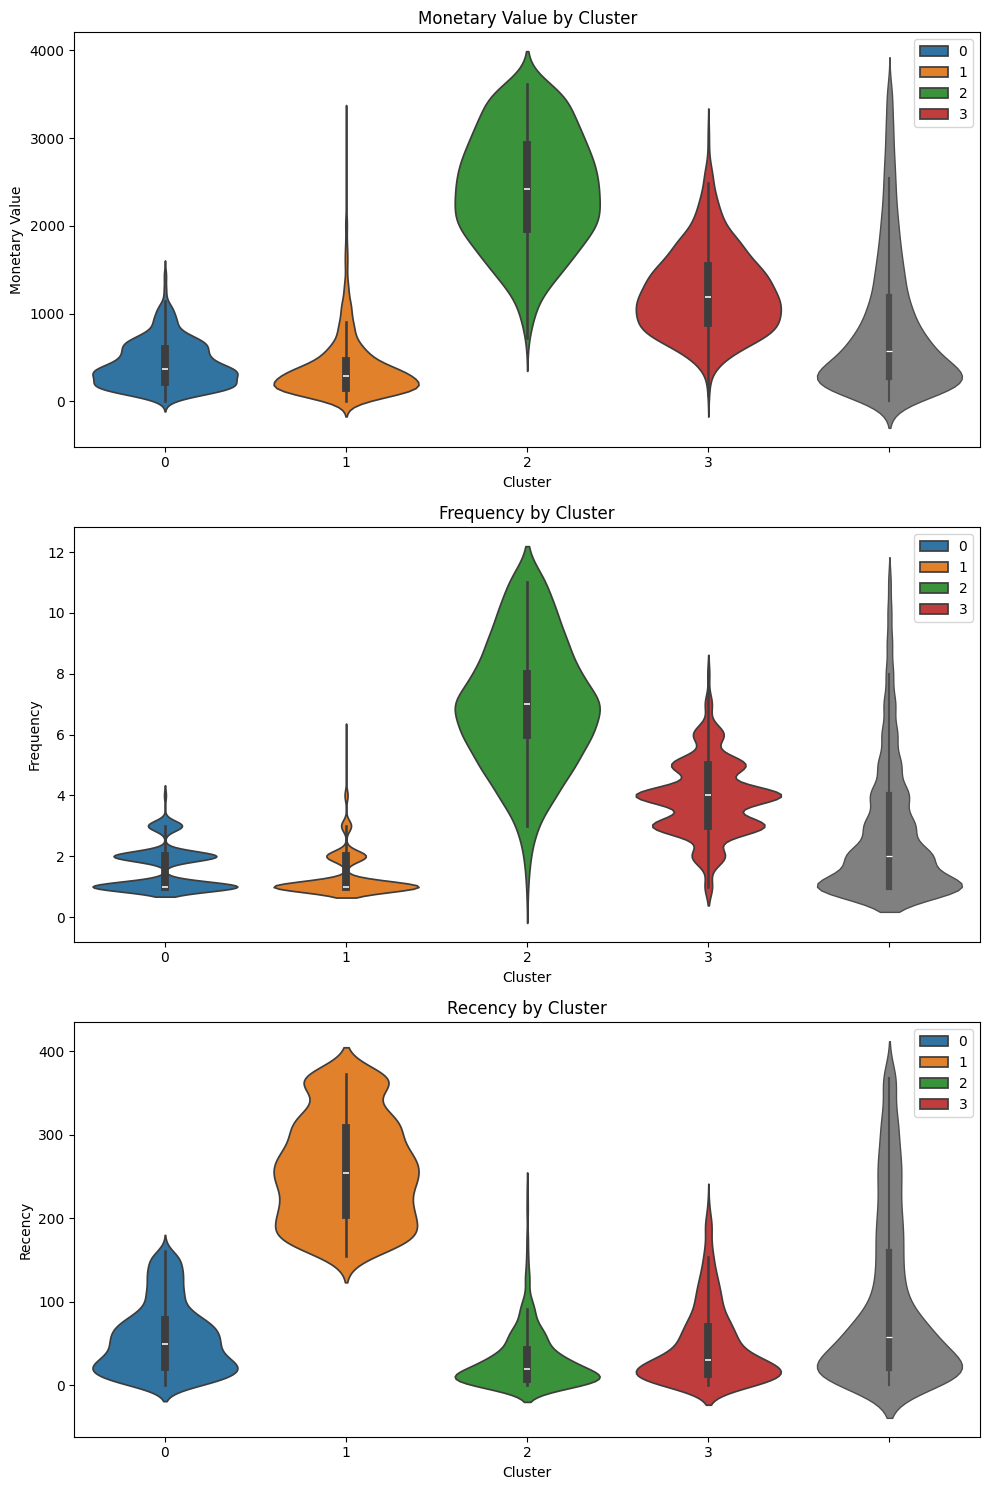

In [50]:
# violin plot
plt.figure(figsize=(10, 15))
# Monetary Value
plt.subplot(3, 1, 1)
sns.violinplot(x=non_outliers_df['Cluster'], y=non_outliers_df['MonetaryValue'], palette=cluster_colors, hue=non_outliers_df["Cluster"])
sns.violinplot(y=non_outliers_df['MonetaryValue'], color='gray', linewidth=1.0)
plt.title('Monetary Value by Cluster')
plt.ylabel('Monetary Value')
# Frequency
plt.subplot(3, 1, 2)
sns.violinplot(x=non_outliers_df['Cluster'], y=non_outliers_df['Frequency'], palette=cluster_colors, hue=non_outliers_df["Cluster"])
sns.violinplot(y=non_outliers_df['Frequency'], color='gray', linewidth=1.0)
plt.title('Frequency by Cluster')
plt.ylabel('Frequency')

# Recency
plt.subplot(3, 1, 3)
sns.violinplot(x=non_outliers_df['Cluster'], y=non_outliers_df['Recency'], palette=cluster_colors, hue=non_outliers_df["Cluster"])
sns.violinplot(y=non_outliers_df['Recency'], color='gray', linewidth=1.0)
plt.title('Recency by Cluster')
plt.ylabel('Recency')

plt.tight_layout()

0: M thấp, F thấp, R thấp -> Khách hàng tiềm năng 
1: M trải dài 0 - 4000, chủ yếu vẫn ở khoản 0 - 1500, F thấp, R cao 100 - 400: là nhóm khách hàng có nguy cơ hoặc đã rời bỏ
2: M cao nhất, R trải dài, cao nhất trong 4 nhóm, R thấp: nhóm khách hàng trung thành thường xuyên mua hàng

In [51]:
non_outliers_df['Cluster'].value_counts()

Cluster
0    1549
1     942
3     890
2     482
Name: count, dtype: int64

In [52]:
# outliers by Monetary Value and Frequency
overlap_indices = monetary_outliers_df.index.intersection(frequency_outliers_df.index)

monetary_only_outliers = monetary_outliers_df.drop(overlap_indices)
frequency_only_outliers = frequency_outliers_df.drop(overlap_indices)
monetary_and_frequency_outliers = monetary_outliers_df.loc[overlap_indices]
# phân các giá trị outlier thành 3 nhóm 
monetary_only_outliers["Cluster"] = -1
frequency_only_outliers["Cluster"] = -2
monetary_and_frequency_outliers["Cluster"] = -3
# gộp thành df
outlier_clusters_df = pd.concat([monetary_only_outliers, frequency_only_outliers, monetary_and_frequency_outliers])

outlier_clusters_df

,CustomerID,MonetaryValue,Frequency,Recency,Cluster
0,12346,77183.60,1,325,-1
1,12347,4310.00,7,1,-1
10,12357,6207.67,1,32,-1
12,12359,6372.58,4,57,-1
15,12362,4737.23,10,2,-1
...,...,...,...,...,...
4248,18172,7561.68,20,14,-3
4268,18198,5425.56,17,3,-3
4287,18223,6484.54,14,4,-3
4289,18225,5509.12,12,2,-3


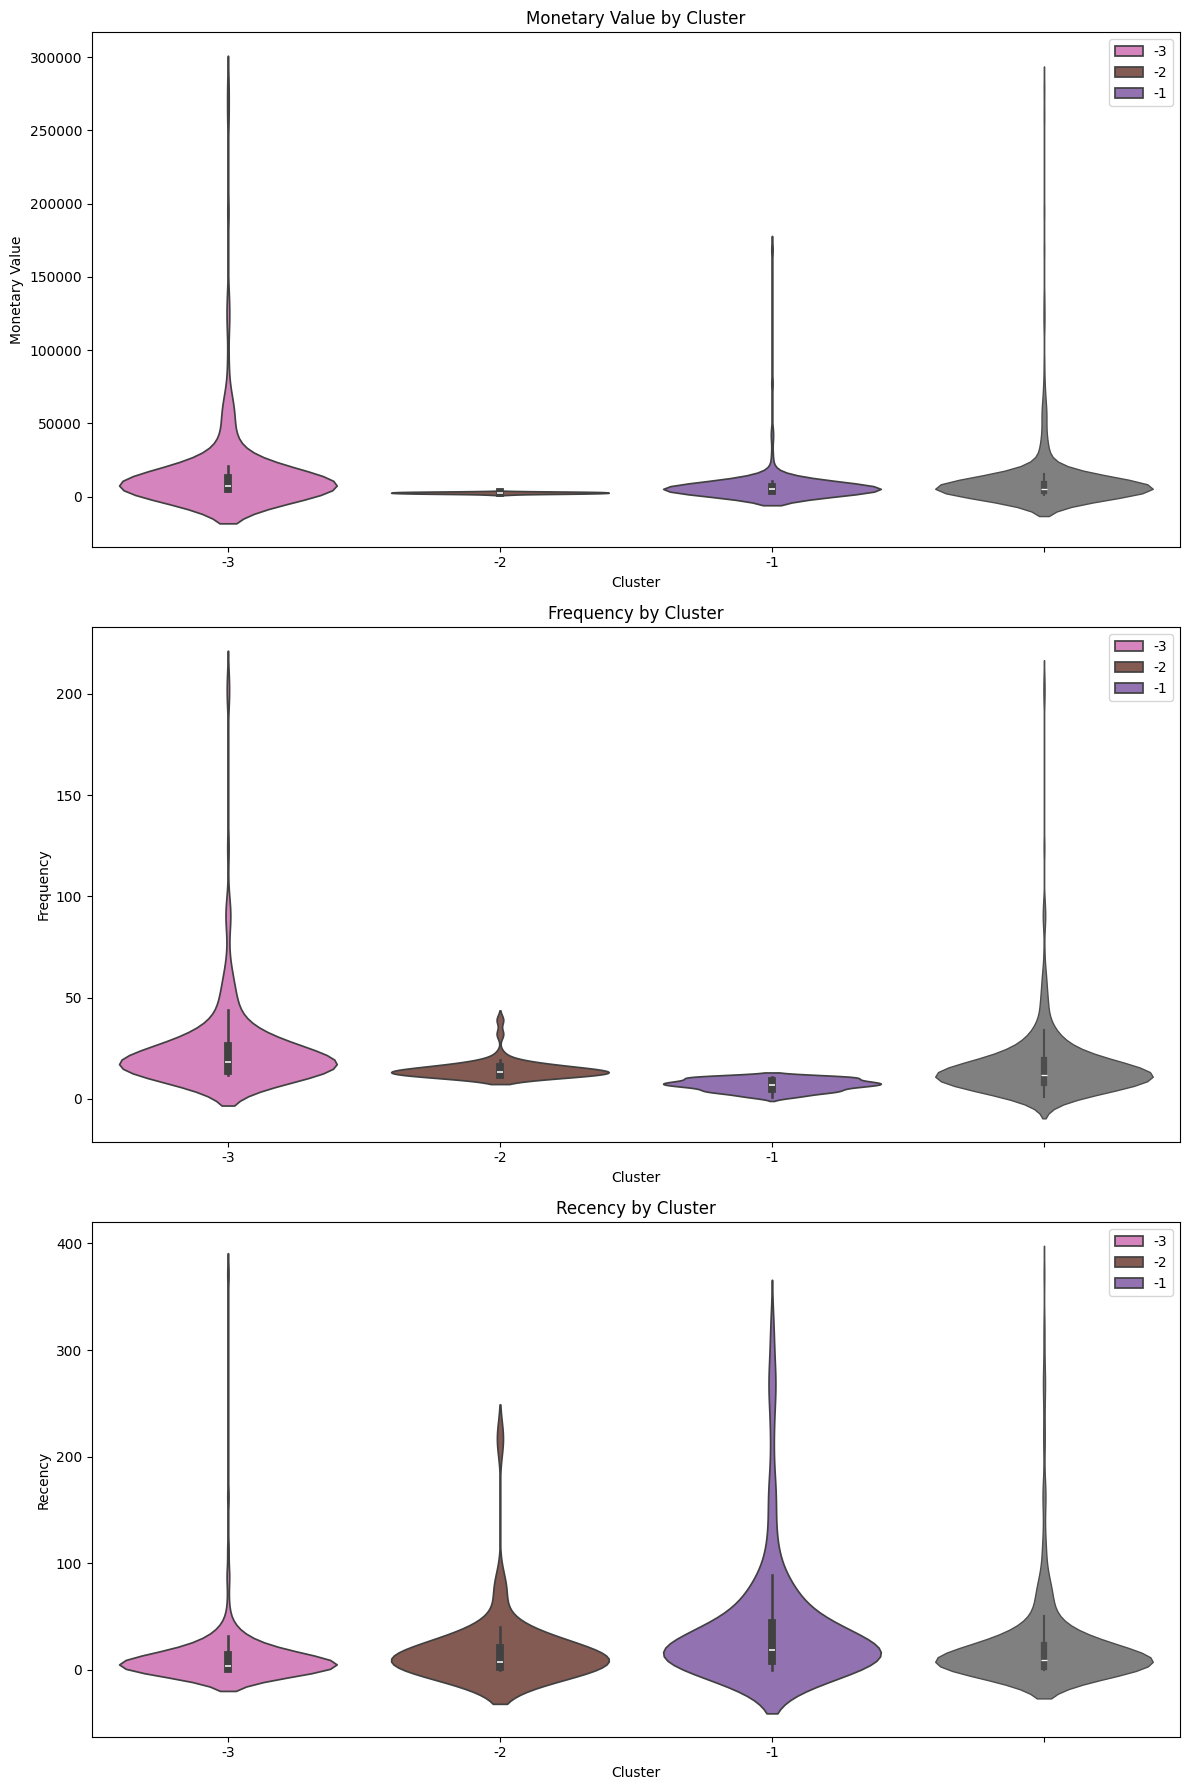

In [53]:
cluster_colors = {-1: '#9467bd',
                  -2: '#8c564b',
                  -3: '#e377c2'}

plt.figure(figsize=(12, 18))
# Monetary Value
plt.subplot(3, 1, 1)
sns.violinplot(x=outlier_clusters_df['Cluster'], y=outlier_clusters_df['MonetaryValue'], palette=cluster_colors, hue=outlier_clusters_df["Cluster"])
sns.violinplot(y=outlier_clusters_df['MonetaryValue'], color='gray', linewidth=1.0)
plt.title('Monetary Value by Cluster')
plt.ylabel('Monetary Value')
# Frequency
plt.subplot(3, 1, 2)
sns.violinplot(x=outlier_clusters_df['Cluster'], y=outlier_clusters_df['Frequency'], palette=cluster_colors, hue=outlier_clusters_df["Cluster"])
sns.violinplot(y=outlier_clusters_df['Frequency'], color='gray', linewidth=1.0)
plt.title('Frequency by Cluster')
plt.ylabel('Frequency')
# Recency
plt.subplot(3, 1, 3)
sns.violinplot(x=outlier_clusters_df['Cluster'], y=outlier_clusters_df['Recency'], palette=cluster_colors, hue=outlier_clusters_df["Cluster"])
sns.violinplot(y=outlier_clusters_df['Recency'], color='gray', linewidth=1.0)
plt.title('Recency by Cluster')
plt.ylabel('Recency')

plt.tight_layout()

In [54]:
# 2 - xanh lá, khách hàng vip
# 1 - khách rời bỏ
# 0 - khách tiềm năng
# 3 - khách hàng bình thường

cluster_labels = {
    0: "NURTURE",                  # Chăm sóc khách hàng tiềm năng
    1: "RE-ENGAGE",                # Tương tác lại với khách hàng đã rời đi
    2: "REWARD",                   # Thưởng cho khách hàng trung thành
    3: "RETAIN",                   # Giữ chân khách hàng hiện tại
    -1: "PAMPER",                  # Chiều chuộng khách hàng VIP
    -2: "UPSELL",                  # Đề xuất mua thêm sản phẩm/dịch vụ
    -3: "DELIGHT"                  # Tạo trải nghiệm xuất sắc để làm hài lòng khách hàng
}


In [55]:
# gộp non_outliers and outliers
full_clustering_df = pd.concat([non_outliers_df, outlier_clusters_df])

full_clustering_df

,CustomerID,MonetaryValue,Frequency,Recency,Cluster
2,12348,1437.24,4,74,3
3,12349,1457.55,1,18,0
4,12350,294.40,1,309,1
5,12352,1385.74,7,35,2
6,12353,89.00,1,203,1
...,...,...,...,...,...
4248,18172,7561.68,20,14,-3
4268,18198,5425.56,17,3,-3
4287,18223,6484.54,14,4,-3
4289,18225,5509.12,12,2,-3


In [56]:
# ánh xạ 
full_clustering_df["ClusterLabel"] = full_clustering_df["Cluster"].map(cluster_labels)

full_clustering_df.sample(10)

,CustomerID,MonetaryValue,Frequency,Recency,Cluster,ClusterLabel
265,12672,225.90,1,329,1,RE-ENGAGE
834,13467,1083.71,2,10,0,NURTURE
4136,18014,158.47,1,27,0,NURTURE
1852,14875,1465.32,2,107,3,RETAIN
1300,14110,5683.15,12,3,-3,DELIGHT
3231,16758,369.34,1,64,0,NURTURE
3104,16587,225.15,1,231,1,RE-ENGAGE
2790,16150,2053.02,5,42,2,REWARD
623,13168,1319.19,4,35,3,RETAIN
1251,14045,1659.75,4,108,3,RETAIN


Text(0, 0.5, 'Average Value')

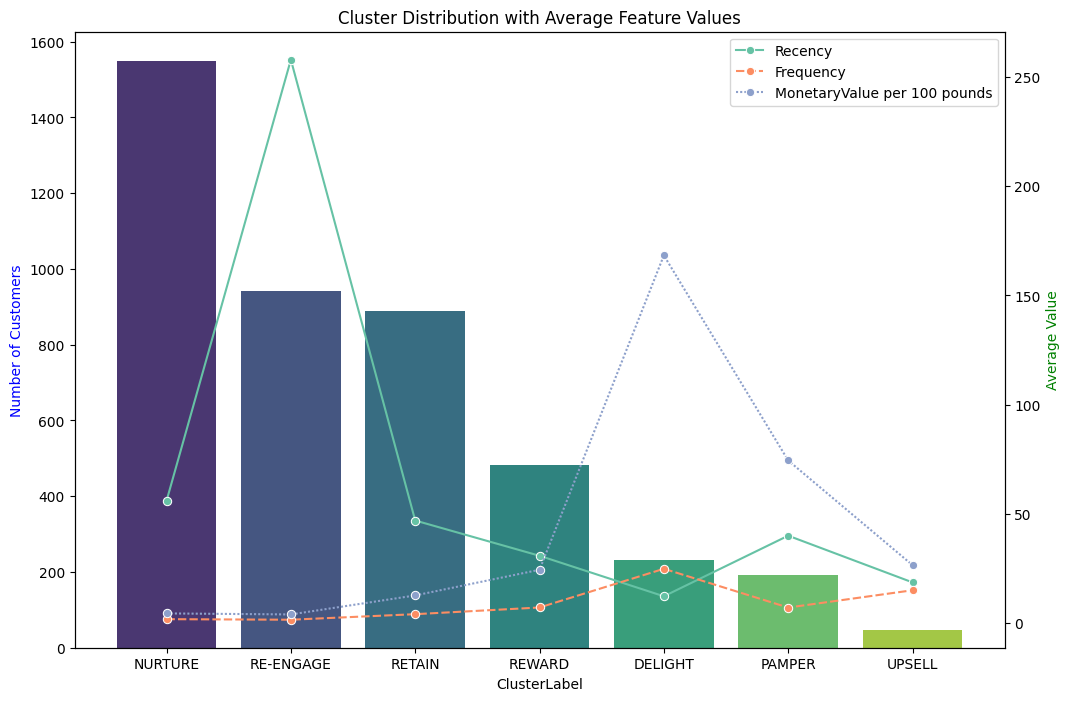

In [57]:
# tính mỗi cụm
cluster_counts = full_clustering_df['ClusterLabel'].value_counts()
full_clustering_df["MonetaryValue per 100 pounds"] = full_clustering_df["MonetaryValue"] / 100.00
# tính mean các biến
feature_means = full_clustering_df.groupby('ClusterLabel')[['Recency', 
                                                            'Frequency', 
                                                            'MonetaryValue per 100 pounds']].mean()

fig, ax1 = plt.subplots(figsize=(12, 8))

sns.barplot(x=cluster_counts.index, y=cluster_counts.values, ax=ax1, palette='viridis', hue=cluster_counts.index)
ax1.set_ylabel('Number of Customers', color='b')
ax1.set_title('Cluster Distribution with Average Feature Values')

ax2 = ax1.twinx()

sns.lineplot(data=feature_means, ax=ax2, palette='Set2', marker='o')
ax2.set_ylabel('Average Value', color='g')
